## Hyper-Personalized Marketing: A Journey with Grok

You’ve dodged the internet’s ad barrage one too many times—pop-ups, banners, that 5-second YouTube teaser you’d trade anything to skip. How many ads hit you daily? How many feel like they get you, not some generic nobody? If you’re a brand, how often do your regulars see offers that truly spark their interest? Spoiler: not nearly enough.

Imagine ads that hook strangers in their native tongue and campaigns that captivate your loyal fans with perfect precision. Large language models like xAI’s Grok make this possible. Once, it was impractical for marketing teams to manually sift through user profiles and craft bespoke messages, too slow, too costly. Now, feed Grok the right context, and it takes over, blending nuanced language mastery with image-generation prowess to deliver hyper-personalized content across languages, formats, and tones in mere seconds.

## Table of Contents
- [Crafting Customers: Grok Builds Your Audience Profiles](#crafting-customers-grok-builds-your-audience-profiles)
  - [Synthetic Customer Generation](#synthetic-customer-generation)
  - [Persona Generation](#persona-generation)
- [Hyper Personalized Prompt](#hyper-personalized-prompt)
- [Image Generation](#image-generation)
  - [Meta-Prompting](#meta-prompting)
- [Final Results](#final-results)
- [Conclusion](#conclusion)

In [66]:
%pip install --quiet openai python-dotenv tqdm pandas aiofiles

Note: you may need to restart the kernel to use updated packages.


### Crafting Customers: Grok Builds Your Audience Profiles

Every campaign needs a target. For ads, it’s new users with basic traits. For marketing, it’s your known crowd, rich with history. Typically, you’d pull from your database, but here, we'll use Grok to create synthetic sample profiles from scratch. First, we'll use the structured outputs feature to create sample customers with attributes that would aid in generating targeted marketing/ad content. Second, we’ll task Grok with fleshing out vivid, concrete personas—written snapshots that bring these profiles to life, ready to inspire hyper-personalized campaigns.

#### Synthetic Customer Generation

Below, we define a Pydantic model to shape sample customers with attributes typical of an e-commerce setting. Then, we harness Grok’s structured outputs feature to whip up 10 diverse profiles in one go.

In [ ]:
import os

from dotenv import load_dotenv
from openai import AsyncOpenAI

load_dotenv()

GROK_2_IMAGE = "grok-2-image"

GROK_4 = "grok-4"

grok_client = AsyncOpenAI(
    base_url="https://api.x.ai/v1", api_key=os.getenv("XAI_API_KEY")
)

In [68]:
from enum import Enum

from pydantic import BaseModel


class Gender(Enum):
    MALE = "MALE"
    FEMALE = "FEMALE"


class Item(BaseModel):
    name: str
    category: str
    price: float
    purchase_date: str


class Customer(BaseModel):
    name: str
    age: int
    location: str
    gender: Gender
    language: str
    purchase_history: list[Item]
    interests: list[str]
    search_history: dict[str, str]
    preferred_device: str
    persona: str | None = None


class Customers(BaseModel):
    customers: list[Customer]

In [69]:
async def generate_customers(
    client: AsyncOpenAI, num_customers: int = 10, model: str = GROK_3
) -> Customers:
    prompt = f"""
    Generate {num_customers} sample customers with the following attributes:
    - age: int
    - location: str
    - gender: Gender
    - language: str
    - purchase_history: list[Item]
    - interests: list[str]
    - search_history: dict[str, str]
    - preferred_device: str

    Here are the attributes of an Item:
    - name: str
    - category: str
    - price: float
    - purchase_date: str

    Each customer generated should varied and distinct from the others: 
    - ensure a variety of languages are represented and not just english, however try to focus on commonly spoken languages instead of niche ones.
    - ensure the customers are from a variety of different countries and not just from one country
    - ensure the language attribute is set to the most commonly spoken language in that country
    - Have more english speaking customers than non-english speaking ones.

    Please set the persona attribute to null for all customers.
    """

    response = await client.beta.chat.completions.parse(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        response_format=Customers,
        temperature=1.2,
    )

    if not response.choices[0].message.parsed:
        raise ValueError("No personas generated")

    return response.choices[0].message.parsed

In [70]:
customers = await generate_customers(grok_client, num_customers=10, model=GROK_3)

In [71]:
for customer in customers.customers:
    print(customer.model_dump_json(indent=2))

{
  "name": "John Smith",
  "age": 34,
  "location": "New York, USA",
  "gender": "MALE",
  "language": "English",
  "purchase_history": [
    {
      "name": "Laptop",
      "category": "Electronics",
      "price": 999.99,
      "purchase_date": "2023-01-15"
    },
    {
      "name": "Headphones",
      "category": "Accessories",
      "price": 89.99,
      "purchase_date": "2023-02-20"
    }
  ],
  "interests": [
    "Technology",
    "Gaming",
    "Travel"
  ],
  "search_history": {
    "recent": "laptop deals",
    "past": "gaming accessories"
  },
  "preferred_device": "Smartphone",
  "persona": null
}
{
  "name": "Emma Brown",
  "age": 28,
  "location": "London, UK",
  "gender": "FEMALE",
  "language": "English",
  "purchase_history": [
    {
      "name": "Winter Coat",
      "category": "Clothing",
      "price": 120.5,
      "purchase_date": "2022-11-10"
    },
    {
      "name": "Boots",
      "category": "Footwear",
      "price": 75.0,
      "purchase_date": "2022-12-05"

#### Persona Generation

With our synthetic customers in hand, we can enrich them with detailed personas—textual summaries that make them feel real. Using the `AsyncClient`, we generate personas for all 10 customers concurrently.

In [72]:
from tqdm.asyncio import tqdm_asyncio


async def generate_persona(
    client: AsyncOpenAI, customer: Customer, model: str = GROK_3
) -> str:
    response = await client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": f"Generate a rich, 1-2 sentence persona for the following customer: {customer.model_dump_json(indent=2)}. The persona should suitable such that it can be used to generate a hyper-personalized ad or marketing piece.",
            }
        ],
    )

    persona = response.choices[0].message.content
    if not persona:
        raise ValueError("No persona generated")

    return persona


async def set_personas(
    client: AsyncOpenAI, customers: list[Customer]
) -> list[Customer]:
    coroutines = [generate_persona(client, customer) for customer in customers]
    personas = await tqdm_asyncio.gather(*coroutines, desc="Generating personas")

    for customer, persona in zip(customers, personas):
        customer.persona = persona

    return customers

In [73]:
updated_customers = await set_personas(grok_client, customers.customers)

Generating personas: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


In [74]:
for customer in updated_customers:
    print(customer.persona)

John Smith, a 34-year-old tech-savvy New Yorker, is a passionate gamer and frequent traveler who relies on his smartphone to stay connected and hunt for the latest electronics deals. Always on the lookout for high-quality gadgets like laptops and headphones, he values cutting-edge technology to enhance both his gaming experiences and on-the-go lifestyle.
Emma Brown, a 28-year-old fashion enthusiast from London, UK, is a stylish and curious individual who loves staying ahead of seasonal trends, as seen in her recent purchases of a winter coat and boots, while also indulging her passions for reading and cooking. Often browsing on her tablet, she actively seeks inspiration for winter fashion and new recipes to elevate her culinary skills.
Michael Johnson is a 45-year-old adventure enthusiast from Sydney, Australia, who loves spending his weekends surfing at the beach or hiking through scenic trails, often capturing stunning landscapes with his camera. With a passion for outdoor activities

### Hyper Personalized Prompt

With customers and personas ready, it’s time to craft hyper-personalized marketing messages. The prompt below instructs Grok to generate short, punchy ads tailored to each customer’s unique profile, think 50-100 words that pop with excitement, weave in at least three specific attributes (like age, interests, or purchase history), and match their language and local vernacular. These messages pitch a fresh product tied to their data, complete with a compelling hook and a clear call-to-action.

The prompt below includes a number of techniques that help get the best out of Grok these include:
- Role assignment
- A well defined task with specific criteria
- Detailed step by step instructions on how to perform the task
- Constraints to tell Grok what to avoid
- A reminder towards of the end of the prompt of the most important high-level instructions

In [75]:
async def generate_marketing_piece(
    client: AsyncOpenAI, customer: Customer, model: str = GROK_3
) -> str:
    prompt = f"""
    You are an expert marketing content generator tasked with creating hyper-personalized, engaging, and exciting advertising content for individual customers. Your goal is to leverage detailed customer data to craft tailored messages that resonate with their demographics, behaviors, and preferences, while optionally aligning with a brand style guide where possible.

    Below is the Customer schema outlining the attributes that will be provided as input:
    {Customer.model_json_schema()}

    Task
    Given a single `Customer` instance (provided as input), generate a short, personalized marketing message (50-100 words) that:
    1. Feels exciting, urgent, or exclusive to grab attention.
    2. Incorporates at least 3 specific attributes from the customer's data (e.g., `age`, `purchase_history`, `interests`).
    3. Matches the customer's `language` and uses idiomatic lingo based on the customer's `location`.
    4. Aligns with their `preferred_device` for delivery.
    5. Suggests a specific product or service (either dynamically generated or inferred from data) tied to their purchase history, interests, or search history - but not something they have recently purchased.

    Instructions
    1. Analyze the Customer: Use attributes like `age`, `gender`, `location`, `purchase_history`, `interests`, `search_history`, and `preferred_device` to understand the customer. If `persona` is missing, infer a simple persona (e.g., "Tech-Savvy Gamer," "Eco-Chic Shopper") based on patterns.
    2. Generate a Product/Service (if not provided): If no specific product is given, create one based on the customer’s data. Example: For a customer with `interests: ["sustainability"]` and `purchase_history: ["Dress"]`, suggest a "Vegan Leather Bag" in the "Fashion" category for $45.
    2. Personalized Greeting: Always address the customer by their first name in the greeting
    3. Tailor the Tone: Adjust language and style to suit `age`, `gender`, and `interests`. For younger audiences, use casual, vibrant tones; for older audiences, use polished, professional tones.
    4. Use the language of the customer: Use idiomatic vernacular based on the customer's `location`.
    5. Use emojis: Use emojis to add a bit more flair to the message, but don't overdo it.
    6. Leverage Context: Reference `location` (e.g., local events), `purchase_date` (e.g., time since last purchase), or `search_history` (e.g., intent) for relevance.
    7. Create Hooks: Use storytelling ("Remember your last buy?"), exclusivity ("For our top shoppers only"), or FOMO ("This week only!") to engage.
    8. Personalize Offers: Suggest the product with a compelling deal (e.g., discount, bundle) tied to `purchase_history` or `search_history`. Use plausible pricing if generating a product.
    9. Optimize Delivery: Format for `preferred_device`—short and visual for "mobile," detailed for "desktop."
    10. Stay Concise: Keep the message 50-100 words, punchy, and action-oriented with a clear call-to-action (CTA), using new lines for clarity and structure where necessary.

    Constraints
    - Do not invent customer data not present in the `Customer` instance.
    - Avoid generic phrases like "Dear Customer" unless no personalization data is available.
    - Use the exact `language` specified (e.g., English, Japanese) and match cultural nuances where possible.
    - Do not exceed 100 words unless explicitly requested.

    Remember to:
    - Be creative but grounded in the data.
    - If generating a product, ensure it’s plausible and tied to the customer’s profile.
    - If unsure about cultural references, keep it simple and data-driven.
    - Only output the final advertising content and nothing else.

    Here is the customer:
    {customer.model_dump_json(indent=2, exclude={"persona"})}

    Here is the customer persona:
    {customer.persona}

    Here is the target language:
    {customer.language}
    """
    response = await client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
    )
    if not response.choices[0].message.content:
        raise ValueError("No marketing piece generated")

    return response.choices[0].message.content

In [83]:
marketing_pieces: list[str] = await tqdm_asyncio.gather(
    *[
        generate_marketing_piece(grok_client, customer)
        for customer in updated_customers
    ]
)

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


In [84]:
import pandas as pd

pd.set_option("display.max_colwidth", None)


df = pd.DataFrame(
    {
        "Customer JSON": [
            customer.model_dump_json(indent=2) for customer in updated_customers
        ],
        "Customer Persona": [customer.persona for customer in updated_customers],
        "Marketing Piece": marketing_pieces,
    }
)

df

,Customer JSON,Customer Persona,Marketing Piece
0,"{\n ""name"": ""John Smith"",\n ""age"": 34,\n ""location"": ""New York, USA"",\n ""gender"": ""MALE"",\n ""language"": ""English"",\n ""purchase_history"": [\n {\n ""name"": ""Laptop"",\n ""category"": ""Electronics"",\n ""price"": 999.99,\n ""purchase_date"": ""2023-01-15""\n },\n {\n ""name"": ""Headphones"",\n ""category"": ""Accessories"",\n ""price"": 89.99,\n ""purchase_date"": ""2023-02-20""\n }\n ],\n ""interests"": [\n ""Technology"",\n ""Gaming"",\n ""Travel""\n ],\n ""search_history"": {\n ""recent"": ""laptop deals"",\n ""past"": ""gaming accessories""\n },\n ""preferred_device"": ""Smartphone"",\n ""persona"": ""John Smith, a 34-year-old tech-savvy New Yorker, is a passionate gamer and frequent traveler who relies on his smartphone to stay connected and hunt for the latest electronics deals. Always on the lookout for high-quality gadgets like laptops and headphones, he values cutting-edge technology to enhance both his gaming experiences and on-the-go lifestyle.""\n}","John Smith, a 34-year-old tech-savvy New Yorker, is a passionate gamer and frequent traveler who relies on his smartphone to stay connected and hunt for the latest electronics deals. Always on the lookout for high-quality gadgets like laptops and headphones, he values cutting-edge technology to enhance both his gaming experiences and on-the-go lifestyle.","Hey John, ready to level up your gaming on the go? As a tech-savvy New Yorker, we know you love cutting-edge gear. Since you snagged that laptop and headphones earlier this year, how about the ultimate accessory—a portable Gaming Monitor for just $199? It’s perfect for crushing it wherever your travels take you! This exclusive deal is only for our top shoppers like you, but hurry, it’s this week only! Tap now to grab yours and dominate the game. 🕹️ Check it out on your smartphone today!"
1,"{\n ""name"": ""Emma Brown"",\n ""age"": 28,\n ""location"": ""London, UK"",\n ""gender"": ""FEMALE"",\n ""language"": ""English"",\n ""purchase_history"": [\n {\n ""name"": ""Winter Coat"",\n ""category"": ""Clothing"",\n ""price"": 120.5,\n ""purchase_date"": ""2022-11-10""\n },\n {\n ""name"": ""Boots"",\n ""category"": ""Footwear"",\n ""price"": 75.0,\n ""purchase_date"": ""2022-12-05""\n }\n ],\n ""interests"": [\n ""Fashion"",\n ""Reading"",\n ""Cooking""\n ],\n ""search_history"": {\n ""recent"": ""winter fashion"",\n ""past"": ""cooking recipes""\n },\n ""preferred_device"": ""Tablet"",\n ""persona"": ""Emma Brown, a 28-year-old fashion enthusiast from London, UK, is a stylish and curious individual who loves staying ahead of seasonal trends, as seen in her recent purchases of a winter coat and boots, while also indulging her passions for reading and cooking. Often browsing on her tablet, she actively seeks inspiration for winter fashion and new recipes to elevate her culinary skills.""\n}","Emma Brown, a 28-year-old fashion enthusiast from London, UK, is a stylish and curious individual who loves staying ahead of seasonal trends, as seen in her recent purchases of a winter coat and boots, while also indulging her passions for reading and cooking. Often browsing on her tablet, she actively seeks inspiration for winter fashion and new recipes to elevate her culinary skills.","Hey Emma, ready to slay this winter in true London style? Since you’ve already rocked that Winter Coat and Boots, we’ve got something fab for you—a stunning Vegan Leather Scarf to complete your look! Inspired by your love for fashion and recent “winter fashion” searches, we’re offering it at 20% off, just for our trendsetters. Hurry, this exclusive deal won’t last past this week! Pop over to our site on your tablet and snag it now. Let’s keep you stylish, mate! 🧣"
2,"{\n ""name"": ""Michael Johnson"",\n ""age"": 45,\n ""location"": ""Sydney, Australia"",\n ""gender"": ""MALE"",\n ""language"": ""English"",\n ""purchase_history"": [\n {\n ""name"": ""Surfboard"",\n ""category"": ""S

In just a matter of seconds we've created hyper personalized relevant marketing material, in a variety of vastly different languages, with idiomatic language. Our prompt above focuses on short punchy ads but this can easily be adjusted to fit a specific format or style to suit your needs.

### Image Generation

Why stop at text? Let’s amp up these marketing pieces with eye-catching images. Using Grok’s [image-generation capabilities](https://docs.x.ai/docs/guides/image-generations), we’ll create visuals based on each marketing message and persona. These images spotlight the product in a stylized, engaging scene—think vibrant watercolors or bold graphics tied to the customer’s interests and lifestyle, all without humans to keep the focus tight.

#### Meta-Prompting

Typically, the image generation API works by taking a prompt that describes the image you want created. We could pass a prompt directly here, but instead, we use a meta-prompt, a prompt fed into a non-image-generation model to craft a tailored prompt optimized for the image gen API. This lets us get ultra-specific, ensuring the generated prompt perfectly aligns with the customer’s persona and marketing piece for standout visuals.

> Note: The image generation API actually takes the prompt you give it and [re-writes](https://docs.x.ai/docs/guides/image-generations#image-generations) it anyway, which might make this step seem redundant. However, even with that re-writing process, providing a high quality and descriptive initial prompt often leads to better quality end images.

In [85]:
async def generate_image_prompt(
    client: AsyncOpenAI,
    marketing_piece: str,
    customer_persona: str,
    model: str = GROK_3,
) -> str:
    meta_prompt = f"""
    Create a concise and detailed prompt optimized for an image generation model based on the persona and marketing piece provided below.

    The generated prompt should:
    - Instruct the model to create an image promoting the product or service from the marketing piece, with the product or service as the central focus.
    - Exclude humans from the image.
    - Place the product or service in a visually engaging, stylized context that reflects the persona’s interests, lifestyle, or preferences.  
    - Include subtle background elements or details that tie into the persona’s characteristics (e.g., hobbies, environment) to enhance relevance, without distracting from the product or service.  
    - Use vivid, descriptive language to inspire a creative and unique visual output, keeping the tone imaginative rather than literal.
    - Instruct the model to use different styles, not all photos need to be hyper-realistic but some may be more artistic, sketched, paintings, watercolor style etc. The style used should be chosen based on the marketing piece and persona.
    - Format the output as a single, flowing sentence or short paragraph, avoiding lists or numbered steps, suitable for direct input into an image generation tool.

    Steps to Generate the Prompt:
    1. Analyze the marketing piece to pinpoint the product or service and its key selling points.
    2. Examine the persona to extract specific traits, interests, or motivations that connect to the product or service.
    3. Craft a scene where the product or service shines in a context meaningful to the persona, such as the city or location, blending in subtle, complementary details based on the persona's characteristics. 
    4. Ensure the language is evocative, visual, and concise, tailored for an image generation model’s interpretation.

    Persona:
    {customer_persona}

    Marketing Piece:
    {marketing_piece}
    """

    response = await client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": meta_prompt}],
        max_tokens=400,
    )

    if not response.choices[0].message.content:
        raise ValueError("No image prompt generated")

    return response.choices[0].message.content

In [86]:
import base64
import os
import uuid

import aiofiles


async def generate_image(
    client: AsyncOpenAI, marketing_piece: str, customer_persona: str, filepath: str
) -> str:
    image_prompt = await generate_image_prompt(
        grok_client, marketing_piece, customer_persona
    )
    print(image_prompt)

    response = await client.images.generate(
        model="grok-2-image", prompt=image_prompt, response_format="b64_json"
    )
    if not response.data:
        raise ValueError("No image generated")

    b64_json = response.data[0].b64_json
    if b64_json is None:
        raise ValueError("No base64 data received in response")

    image_data = base64.b64decode(b64_json)
    filename = os.path.join(filepath, f"generated_image_{uuid.uuid4().hex[:5]}.png")
    async with aiofiles.open(filename, "wb") as f:
        await f.write(image_data)

    return filename

In [87]:
async def generate_all_images(client: AsyncOpenAI, df: pd.DataFrame, images_dir: str):
    tasks = [
        generate_image(
            client, row["Marketing Piece"], row["Customer Persona"], images_dir
        )
        for _, row in df.iterrows()
    ]

    image_paths = await tqdm_asyncio.gather(*tasks)

    df["image_path"] = image_paths
    return df

In [81]:
df = await generate_all_images(grok_client, df, "generated_images/")

  0%|          | 0/10 [00:00<?, ?it/s]

Create a stunning image showcasing a luxurious "Designer Lehenga Choli" as the centerpiece, radiating Bollywood-inspired glamour with intricate embroidery and vibrant jewel tones, elegantly draped over a polished mannequin in the heart of a dreamy Mumbai-inspired setting, where the golden hues of a sunset illuminate the bustling cityscape in the background, with subtle hints of Priya’s world—such as a vintage Bollywood poster peeking from a nearby wall and a small copper cooking pot resting on a market stall—blending seamlessly into the scene without overshadowing the outfit, all rendered in a rich, artistic watercolor style to capture the cultural elegance and emotional warmth of Priya’s vibrant lifestyle.
Create a stunning image that showcases a pair of elegant travel sandals as the centerpiece, artfully arranged on a sun-warmed cobblestone street in the heart of Madrid at golden hour, with the vibrant essence of Maria’s lively spirit infused into the scene through subtle background 

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


### Final Results

Now that we’ve generated images and personas, let’s take a look at how these hyper-personalized marketing pieces come together with their custom visuals to captivate each customer.

Hey John, ready to level up your gaming on the go? As a tech-savvy New Yorker, we know you love cutting-edge gear. Since your last laptop purchase in January, we’ve got something epic for you—a premium Gaming Mouse, perfect for dominating every match! Snag it now for just $49.99 (exclusive 20% off this week only)! Don’t miss out; this deal won’t last long in the Big Apple. Tap here on your smartphone to grab yours before it’s game over! 🎮💥



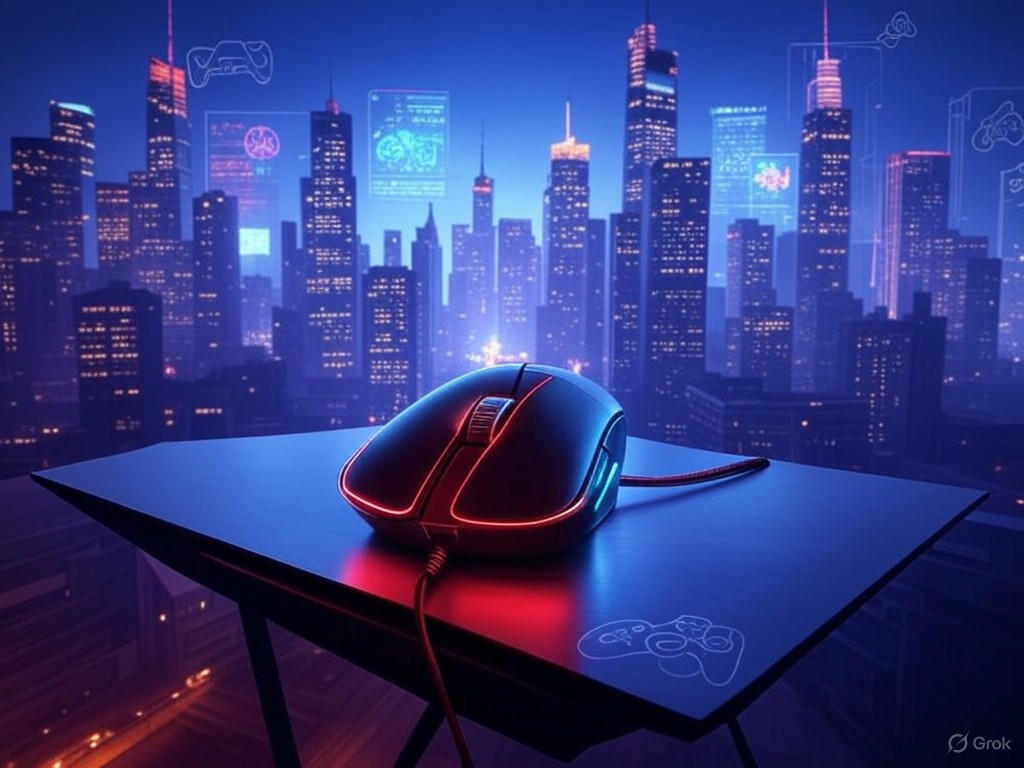


Hey Emma, ready to slay this winter in style? As a true London fashionista at 28, we know you love rocking the latest trends with your recent winter coat and boots! We've got an exclusive deal just for you – a stunning Wool-Blend Scarf for only £29.99 to complete your look. Perfect for those chilly London streets! Hurry, this offer is for this week only. Tap now on your tablet to grab it before it’s gone! 🧣 Stay fabulous!



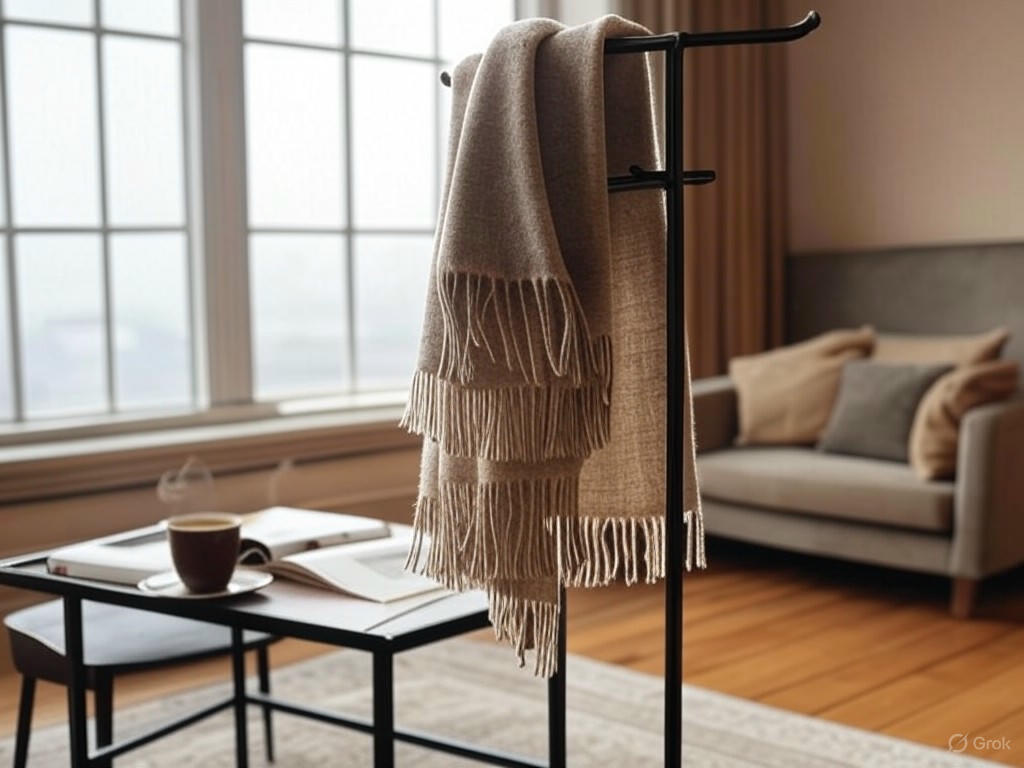


G’day Michael! Ready to elevate your beach game? Since your epic surfboard purchase earlier this year, we’ve got something special for you. Check out our premium Beach Gear Kit—perfect for your surfing adventures in Sydney. It’s packed with essentials (minus the sunscreen you already snagged!) for just $59.99, exclusive to our top adventurers like you. Don’t miss out—this offer rides the wave for this week only! Surf over to our site on your laptop and grab yours now. Let’s hit the beach, mate! 🏄‍♂️



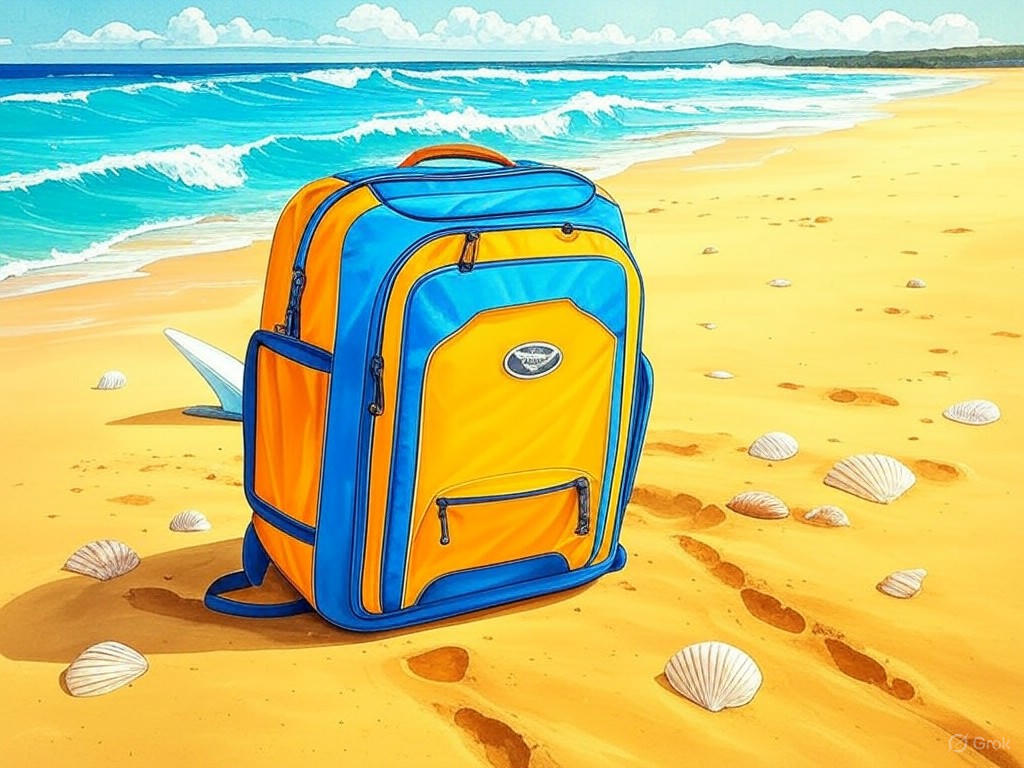


Hey Sarah, ready to elevate your Toronto pad? We’ve got an exclusive deal just for you—a stunning “Literary Art Print” for only $35! Perfect for your bookshelf vibe, this piece blends your love for literature and art into one masterpiece. Imagine it inspiring your next novel read! But hurry, this offer’s only live this week. Tap now to snag it before it’s gone—crafted just for creative souls like you. Check it out on your smartphone today! 🎨📚



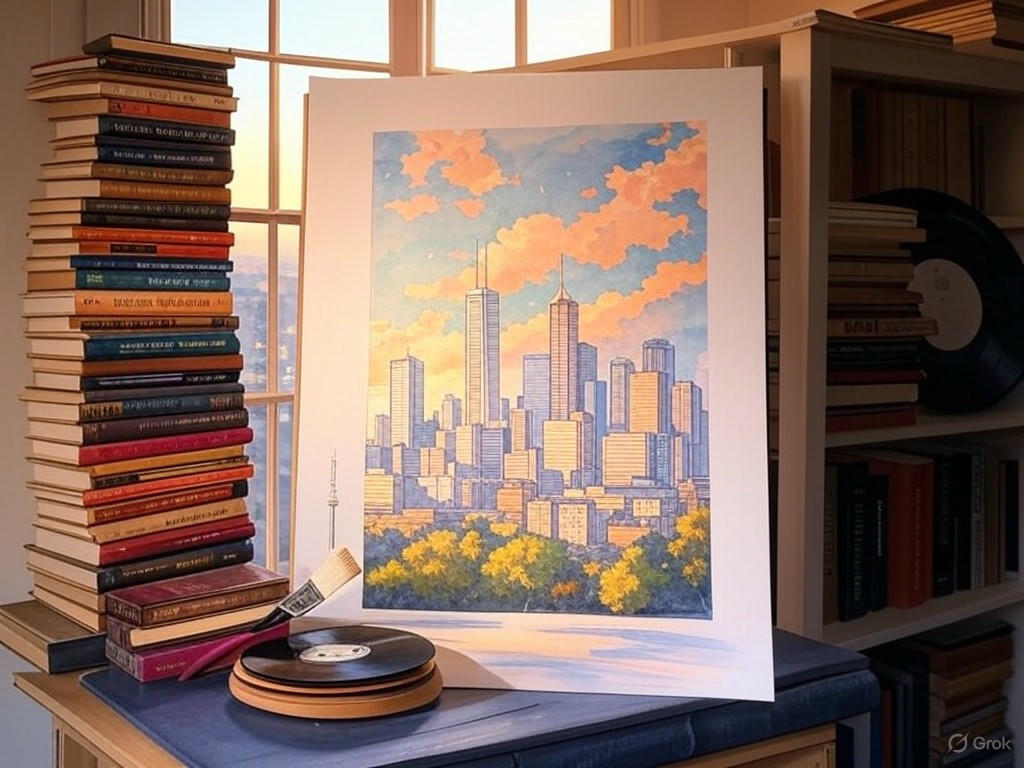


Hey Robert,

Your garden in Manchester is calling for an upgrade! Remember those cracking garden tools you snagged last year? We’ve got something new for you – an exclusive Smart Irrigation System, perfect for your gardening passion and DIY projects. Inspired by your search for garden designs, this £99 gem will save time and keep your lawn lush!

As a top customer, enjoy 15% off this week only. Dive into the details on your desktop and transform your space today. Click now to grab this deal before it’s gone! 🌱



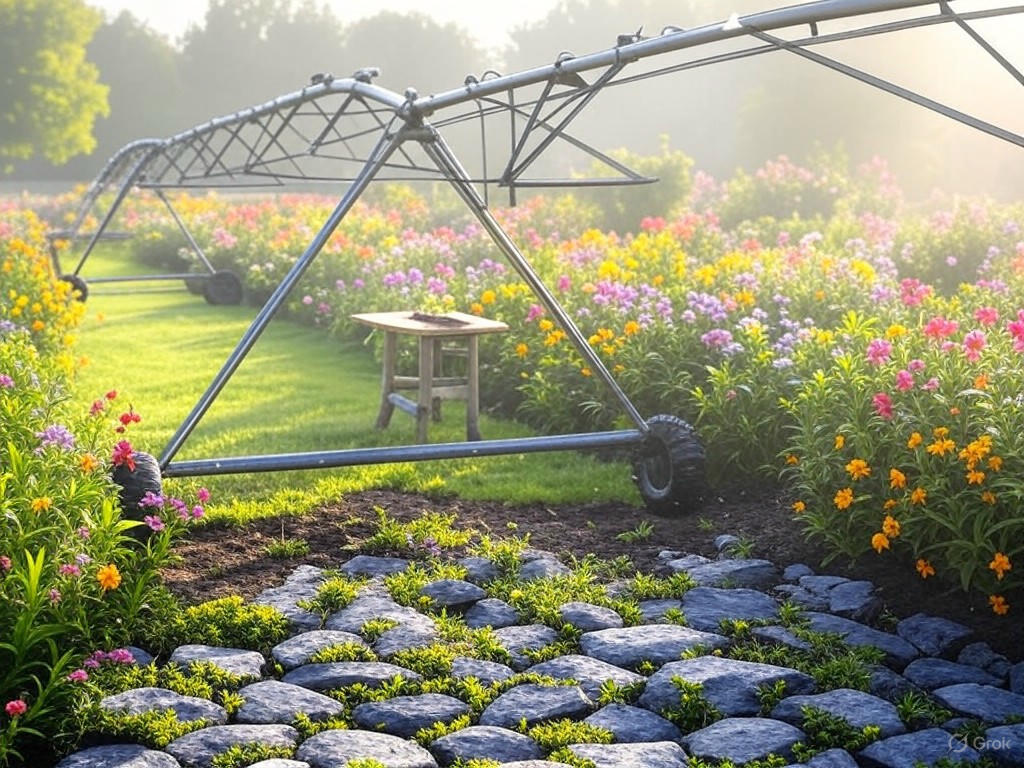


¡Hola, Maria! ¿Lista para brillar este verano en Madrid? Sabemos que amas la moda y el baile, y tras tu última compra de ese vestido fabuloso, ¡tenemos algo especial para ti! Descubre nuestra nueva colección de sandalias de viaje, perfectas para tus aventuras y noches de baile. Solo por esta semana, llévate un par con 20% de descuento. ¡No te lo pierdas! Haz clic ahora desde tu móvil y añade estilo a tus pasos. 💃✨



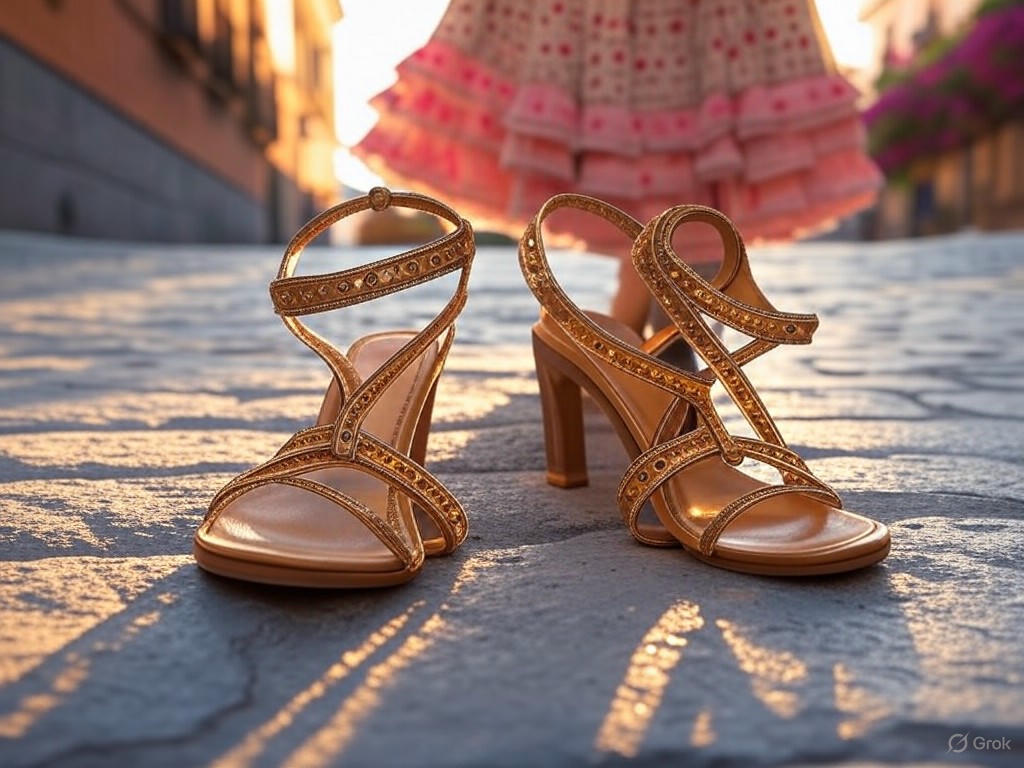


Olá, Lucas! ⚽  
Você, apaixonado por futebol, não pode perder essa! Aqui em São Paulo, sabemos que o jogo nunca para, então trouxemos algo especial pra você. Que tal um par de chuteiras top de linha, perfeitas pra arrasar no campo? Inspirado no seu amor por soccer e nas suas buscas por jogos, oferecemos 20% de desconto só essa semana!  
Acesse agora pelo seu tablet e garanta as suas antes que acabem. Vem com a gente, craque!  
Clique aqui e marque esse gol!



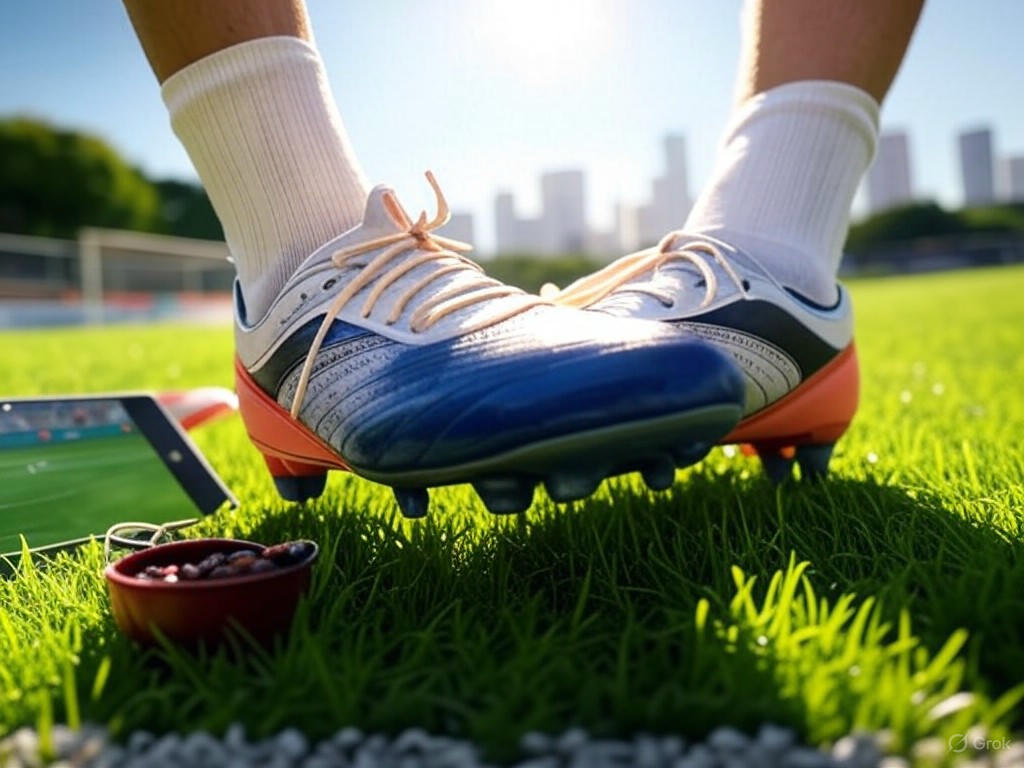


Hey Anna,

Hast du Lust, deine Radtouren in Berlin auf das nächste Level zu bringen? Als passionierte Radfahrerin (dein Bike-Kauf letztes Jahr war top!) und Fotografie-Liebhaberin haben wir genau das Richtige für dich: Eine wasserdichte Action-Kamera für nur 129 € – perfekt, um deine Abenteuer festzuhalten! Nur diese Woche exklusiv für unsere treuen Kunden. Schau dir die Details auf deinem Laptop an und schnapp dir dieses Angebot, bevor es weg ist! 🚴‍♀️📸

Klick jetzt und starte dein nächstes Abenteuer!

Liebe Grüße,
Dein Team



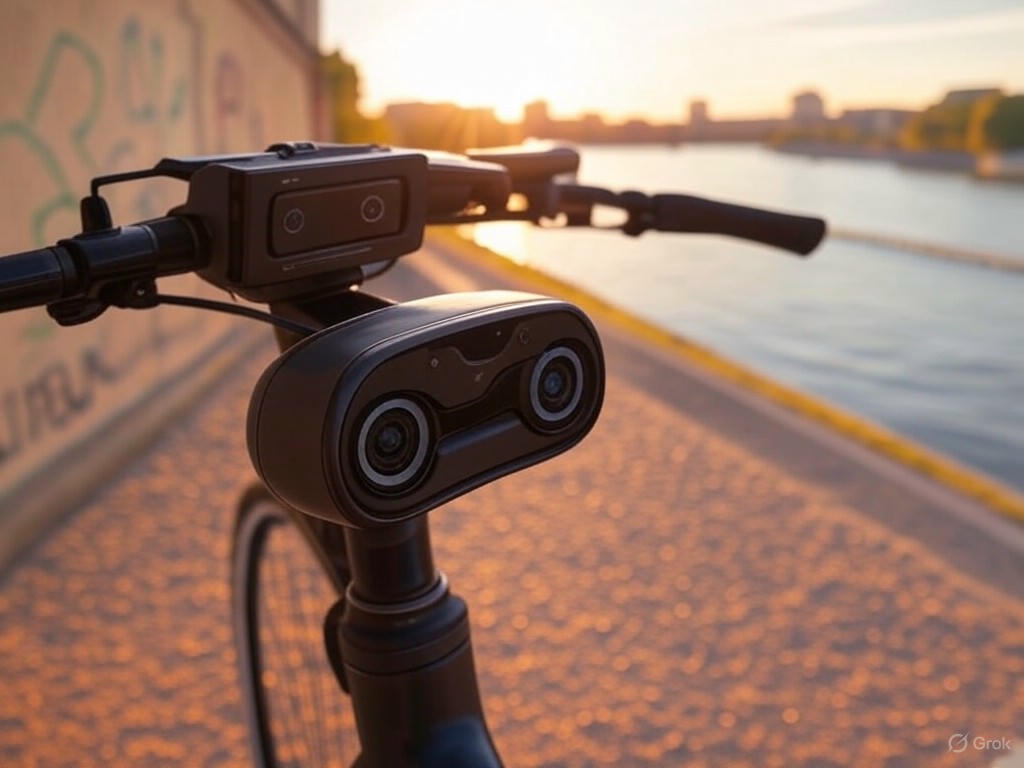


प्रिया, नमस्ते! आपके स्टाइल को देखते हुए, हमें लगता है कि आपको हमारी नई "डिज़ाइनर लहंगा चोली" पसंद आएगी, जो बॉलीवुड की चमक से प्रेरित है! 💃 आपके हाल के साड़ी खरीद (अप्रैल 2023) और साड़ी डिज़ाइनों की खोज को ध्यान में रखते हुए, यह खास ऑफर सिर्फ आपके लिए है। इस हफ्ते ही 20% डिस्काउंट पर इसे अपने वॉर्डरोब में शामिल करें! मंबई की गलियों में सबसे स्टाइलिश दिखें। अभी अपने स्मार्टफोन पर क्लिक करें और खरीदें, ऑफर सीमित समय के लिए है!



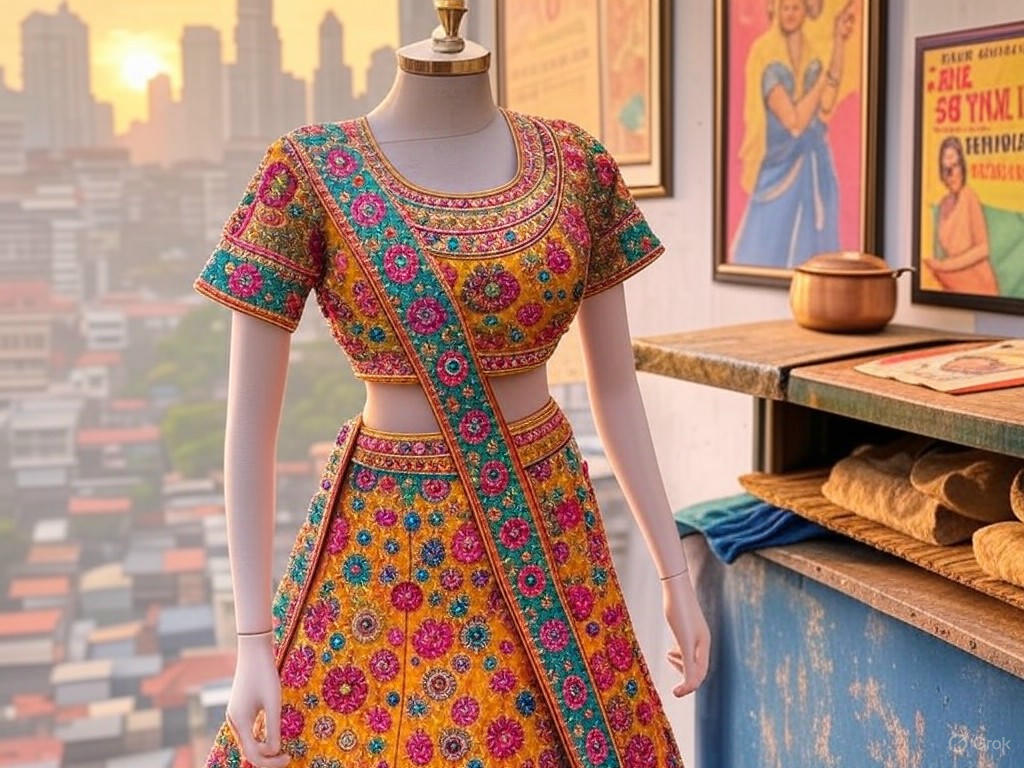


Hey James, ready to elevate your photography game? We’ve got an exclusive deal just for you, straight from the heart of Los Angeles! Since you snagged that camera and tripod, how about a premium camera lens to capture those epic travel shots and movie-inspired scenes? This week only, grab it at 20% off—perfect for your next adventure. Check out the stunning specs and reviews on your laptop now. Don’t miss out, mate—this deal won’t wait! Click to claim yours today! 📸



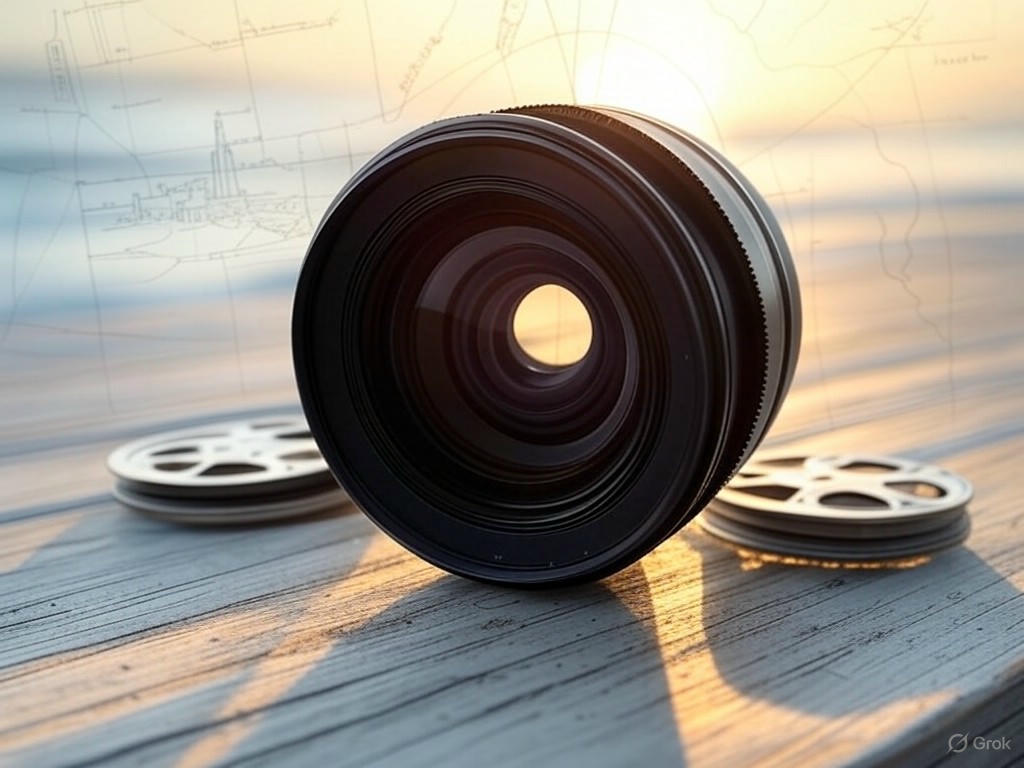

In [82]:
from IPython.display import Image

for index, row in df.iterrows():
    print(f"{row['Marketing Piece']}\n")
    display(Image(row["image_path"], width=600))
    print()

Pretty cool!

## Conclusion

Starting with nothing, we’ve built a powerful pipeline that runs in the order of minutes to deliver hyper-personalized marketing messages along with custom images for each user. Let's quickly recap some of what we covered:

- Synthetic Data Generation using Structured Outputs
- Using prompt engineering best practices to generate hyper personalized marketing messages
- Using meta prompting to generate prompts optimized for image generation

We only scratched the surface, here are some ideas for you to try to take this even further:
- Update the text generation prompt to incorporate you're organization's brand voice/style guide
- Update the text generation prompt so that it can adhere to a specific template for the generated message.

